## dependencies

In [1]:
import gym
from gym import Env 
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete


In [2]:
# import helpers
import numpy as np
import random
import os

In [3]:
# stable baselines 3 
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

## Types of spaces

In [4]:
Discrete(3).sample()

0

In [5]:
Box(0,1, shape=(3,3)).sample()

array([[0.07737886, 0.19643754, 0.9928123 ],
       [0.74105823, 0.2249253 , 0.5201138 ],
       [0.7926323 , 0.7274244 , 0.7001607 ]], dtype=float32)

In [6]:
Tuple((Discrete(3), Box(0,1, shape=(3,)))).sample()

(2, array([0.7138301 , 0.808974  , 0.78631127], dtype=float32))

In [7]:
Dict({'height': Discrete(2), 'speed': Box(0,100, shape=(1,))}).sample()

OrderedDict([('height', 0), ('speed', array([17.02742], dtype=float32))])

In [8]:
MultiBinary(4).sample()

array([0, 0, 1, 1], dtype=int8)

In [9]:
MultiDiscrete([5,2,9]).sample()

array([4, 1, 4], dtype=int64)

## building Environment
- 

In [10]:
class ShowerEnv(Env):
    def __init__(self):
        # Actions we can take, down, stay, up
        self.action_space = Discrete(3)
        # Temperature array
        self.observation_space = Box(low=np.array([0]), high=np.array([100]))
        # initial shower temperature
        self.state = 38 + random.randint(-3,3)
        # Set shower length,
        self.shower_length = 60
        
    def step(self, action):
        # Apply action
        # 0: -1 (down), 1: 0 stay, 2: +1 (up)
        self.state += action -1 
        
        # Reduce shower length by 1 second
        self.shower_length -= 1 
        
        # Calculate reward
        if self.state >=37 and self.state <=39: 
            # good shower temperature
            reward =1 
        else: 
            reward = -1 
            
        if self.shower_length <=0: 
            # done showering
            done = True 
        else: 
            done = False 
            
        # Apply temperature noise
        self.state += random.randint(-1,1)
        
        # Set placeholder for info
        info = {}
        
        # Return step information
        return self.state, reward, done, info
    
    def render(self):
        # Implement viz
        pass
    
    def reset(self):
        # Reset shower temperature
        self.state = np.array([38 + random.randint(-3,3)]).astype(float)
        
        # Reset shower time
        self.shower_length = 60 
        
        return self.state

In [11]:
env = ShowerEnv()

c:\Users\Tinho\anaconda3\envs\gpu-env\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [12]:
env.observation_space.sample()

array([67.34559], dtype=float32)

In [13]:
env.action_space.sample()

1

## Test environment

In [14]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done: 
        env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward
    print('Episode:{} Score:{}'.format(episode, score))

env.close()

Episode:1 Score:-46
Episode:2 Score:-2
Episode:3 Score:-22
Episode:4 Score:18
Episode:5 Score:-2


## Train

In [15]:
log_path = os.path.join('training', 'logs')
model = PPO('MlpPolicy', env, verbose=1, tensorboard_log=log_path)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\Tinho\anaconda3\envs\gpu-env\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [16]:
model.learn(total_timesteps=20)

Logging to training\logs\PPO_8
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 60       |
|    ep_rew_mean     | -38.5    |
| time/              |          |
|    fps             | 124      |
|    iterations      | 1        |
|    time_elapsed    | 16       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 60           |
|    ep_rew_mean          | -36.2        |
| time/                   |              |
|    fps                  | 169          |
|    iterations           | 2            |
|    time_elapsed         | 24           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0024835155 |
|    clip_fraction        | 0.0217       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   |

# save model

In [97]:
shower_path = os.path.join('training', 'saved_models', 'shower_model_PPO')

In [98]:
model.save(shower_path)

c:\Users\Tinho\anaconda3\envs\gpu-env\lib\site-packages\stable_baselines3\common\save_util.py:278: UserWarning: Path 'training\saved_models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [108]:
evaluate_policy(model, env, n_eval_episodes=10, render=True)

(59.0, 2.4083189157584592)

In [1]:
import numpy as np

# Create a one by two matrix
matrix = np.array([[1, 2]])

# Rows to add
new_rows = np.array([[3, 4], [5, 6]])

# Add the new rows to the matrix
new_matrix = np.vstack((matrix, new_rows))

print(new_matrix)

[[1 2]
 [3 4]
 [5 6]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


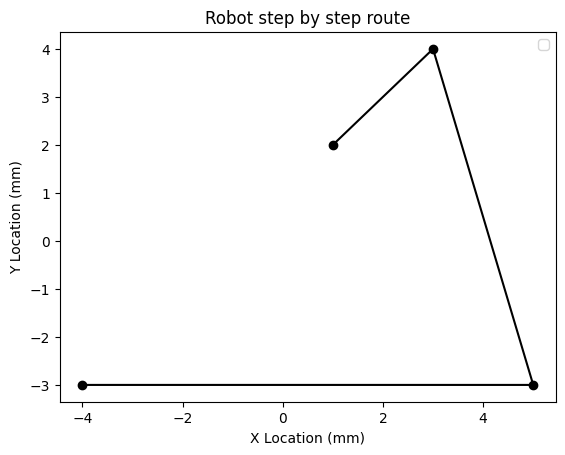

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Create a two-column vector
points = np.array([[1, 2], [3, 4], [5, -3], [-4, -3]])

# Separate x and y coordinates
x = points[:, 0]
y = points[:, 1]

# Create a scatter plot with dots
plt.scatter(x, y, color='black')

# Connect the dots with lines
plt.plot(x, y, color='black', linestyle='solid')
# add a circle of 1000 radius to the plot

# Add labels and legend
plt.xlabel('X Location (mm)')
plt.ylabel('Y Location (mm)')
plt.title('Robot step by step route')
plt.legend()

# Show the plot
plt.show()